<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W1D1_ModelTypes/W1D1_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Types: "How" models
__Original content creators:__ Matt Laporte, Byron Galbraith, Konrad Kording

__Content Modified:__ Kai Chen

___
# Tutorial Objectives
This is tutorial 2 of a 3-part series on different flavors of models used to understand neural data. In this tutorial we will explore models that can potentially explain *how* the spiking data we have observed is produced

To understand the mechanisms that give rise to the neural data we save in Tutorial 1,  we will build simple neuronal models and compare their spiking response to real data. We will:
- Write code to simulate a  simple "leaky integrate-and-fire" neuron model 
- Make the model more complicated — but also more realistic — by adding more physiologically-inspired details

# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
#@title Figure Settings
import ipywidgets as widgets #interactive display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeoNeuron/professional-workshop-3/master/nma.mplstyle")

In [3]:
#@title Helper Functions
def histogram(counts, bins, vlines=(), ax=None, ax_args=None, **kwargs):
  """Plot a step histogram given counts over bins."""
  if ax is None:
    _, ax = plt.subplots()

  # duplicate the first element of `counts` to match bin edges
  counts = np.insert(counts, 0, counts[0])

  ax.fill_between(bins, counts, step="pre", alpha=0.4, **kwargs)  # area shading
  ax.plot(bins, counts, drawstyle="steps", **kwargs)  # lines

  for x in vlines:
    ax.axvline(x, color='r', linestyle='dotted')  # vertical line

  if ax_args is None:
    ax_args = {}

  # heuristically set max y to leave a bit of room
  ymin, ymax = ax_args.get('ylim', [None, None])
  if ymax is None:
    ymax = np.max(counts)
    if ax_args.get('yscale', 'linear') == 'log':
      ymax *= 1.5
    else:
      ymax *= 1.1
      if ymin is None:
        ymin = 0

  if ymax == ymin:
    ymax = None

  ax_args['ylim'] = [ymin, ymax]

  ax.set(**ax_args)
  ax.autoscale(enable=False, axis='x', tight=True)


def plot_neuron_stats(v, spike_times):
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

  # membrane voltage trace
  ax1.plot(v[0:100])
  ax1.set(xlabel='Time', ylabel='Voltage')
  # plot spike events
  for x in spike_times:
    if x >= 100:
      break
    ax1.axvline(x, color='red')

  # ISI distribution
  isi = np.diff(spike_times)
  n_bins = np.arange(isi.min(), isi.max() + 2) - .5
  counts, bins = np.histogram(isi, n_bins)
  vlines = []
  if len(isi) > 0:
    vlines = [np.mean(isi)]
  xmax = max(20, int(bins[-1])+5)
  histogram(counts, bins, vlines=vlines, ax=ax2, ax_args={
    'xlabel': 'Inter-spike interval',
    'ylabel': 'Number of intervals',
    'xlim': [0, xmax]
  })
  plt.show()

# Section 1: The Linear Integrate-and-Fire Neuron

How does a neuron spike? 

A neuron charges and discharges an electric field across its cell membrane. The state of this electric field can be described by the _membrane potential_. The membrane potential rises due to excitation of the neuron, and when it reaches a threshold a spike occurs. The potential resets, and must rise to a threshold again before the next spike occurs.

One of the simplest models of spiking neuron behavior is the linear integrate-and-fire model neuron. In this model, the neuron increases its membrane potential $V_m$ over time in response to excitatory input currents $I$ scaled by some factor $\alpha$:

\begin{align}
  &\Delta V_m = {\alpha}I \\
  &\text{If } V_t>1:\\
  &\quad\text{Spike}\\
  &\quad V_t=0\text{(reset)}\\
\end{align}

Once $V_m$ reaches a threshold value a spike is produced, $V_m$ is reset to a starting value, and the process continues.

Here, we will take the starting and threshold potentials as $0$ and $1$, respectively. So, for example, if $\alpha I=0.1$ is constant---that is, the input current is constant---then $dV_m=0.1$, and at each timestep the membrane potential $V_m$ increases by $0.1$ until after $(1-0)/0.1 = 10$ timesteps it reaches the threshold and resets to $V_m=0$, and so on.

Note that we define the membrane potential $V_m$ as a scalar: a single real (or floating point) number. However, a biological neuron's membrane potential will not be exactly constant at all points on its cell membrane at a given time. We could capture this variation with a more complex model (e.g. with more numbers). Do we need to? 

The proposed model is a 1D simplification. There are many details we could add to it, to preserve different parts of the complex structure and dynamics of a real neuron. If we were interested in small or local changes in the membrane potential, our 1D simplification could be a problem. However, we'll assume an idealized "point" neuron model for our current purpose.

#### Spiking Inputs

Given our simplified model for the neuron dynamics, we still need to consider what form the input $I$ will take. How should we specify the firing behavior of the presynaptic neuron(s) providing the inputs to our model neuron? 

Unlike in the simple example above, where $\alpha I=0.1$, the input current is generally not constant. Physical inputs tend to vary with time. We can describe this variation with a distribution.

We'll assume the input current $I$ over a timestep is due to equal contributions from a non-negative ($\ge 0$) integer number of input spikes arriving in that timestep. Our model neuron might integrate currents from 3 input spikes in one timestep, and 7 spikes in the next timestep. We should see similar behavior when sampling from our distribution.

Given no other information about the input neurons, we will also assume that the distribution has a mean (i.e. mean rate, or number of spikes received per timestep), and that the spiking events of the input neuron(s) are independent in time. Are these reasonable assumptions in the context of real neurons?

A suitable distribution given these assumptions is the Poisson distribution, which we'll use to model $I$:

\begin{align}
  I \sim \mathrm{Poisson}(\lambda)
\end{align}

where $\lambda$ is the mean of the distribution: the average rate of spikes received per timestep.

### Exercise 1: Compute $dV_m$

For your first exercise, you will write the code to compute the change in voltage $dV_m$ (per timestep) of the linear integrate-and-fire model neuron. The rest of the code to handle numerical integration is provided for you, so you just need to fill in a definition for `dv` in the `lif_neuron` function below. The value of $\lambda$ for the Poisson random variable is given by the function argument `rate`.



The [`scipy.stats`](https://docs.scipy.org/doc/scipy/reference/stats.html) package is a great resource for working with and sampling from various probability distributions. We will use the `scipy.stats.poisson` class and its method `rvs` to produce Poisson-distributed random samples. In this tutorial, we have imported this package with the alias `stats`, so you should refer to it in your code as `stats.poisson`.

In [4]:
def lif_neuron(n_steps=1000, alpha=0.01, rate=10):
  """ Simulate a linear integrate-and-fire neuron.

  Args:
    n_steps (int): The number of time steps to simulate the neuron's activity.
    alpha (float): The input scaling factor
    rate (int): The mean rate of incoming spikes

  """
  # precompute Poisson samples for speed
  exc = stats.poisson(rate).rvs(n_steps)

  v = np.zeros(n_steps)
  spike_times = []

  ################################################################################
  # Students: compute dv, then comment out or remove the next line
  raise NotImplementedError("Excercise: compute the change in membrane potential")
  ################################################################################

  for i in range(1, n_steps):

    dv = ...

    v[i] = v[i-1] + dv
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0

  return v, spike_times

# Uncomment these lines after completing the lif_neuron function
# v, spike_times = lif_neuron()
# plot_neuron_stats(v, spike_times)

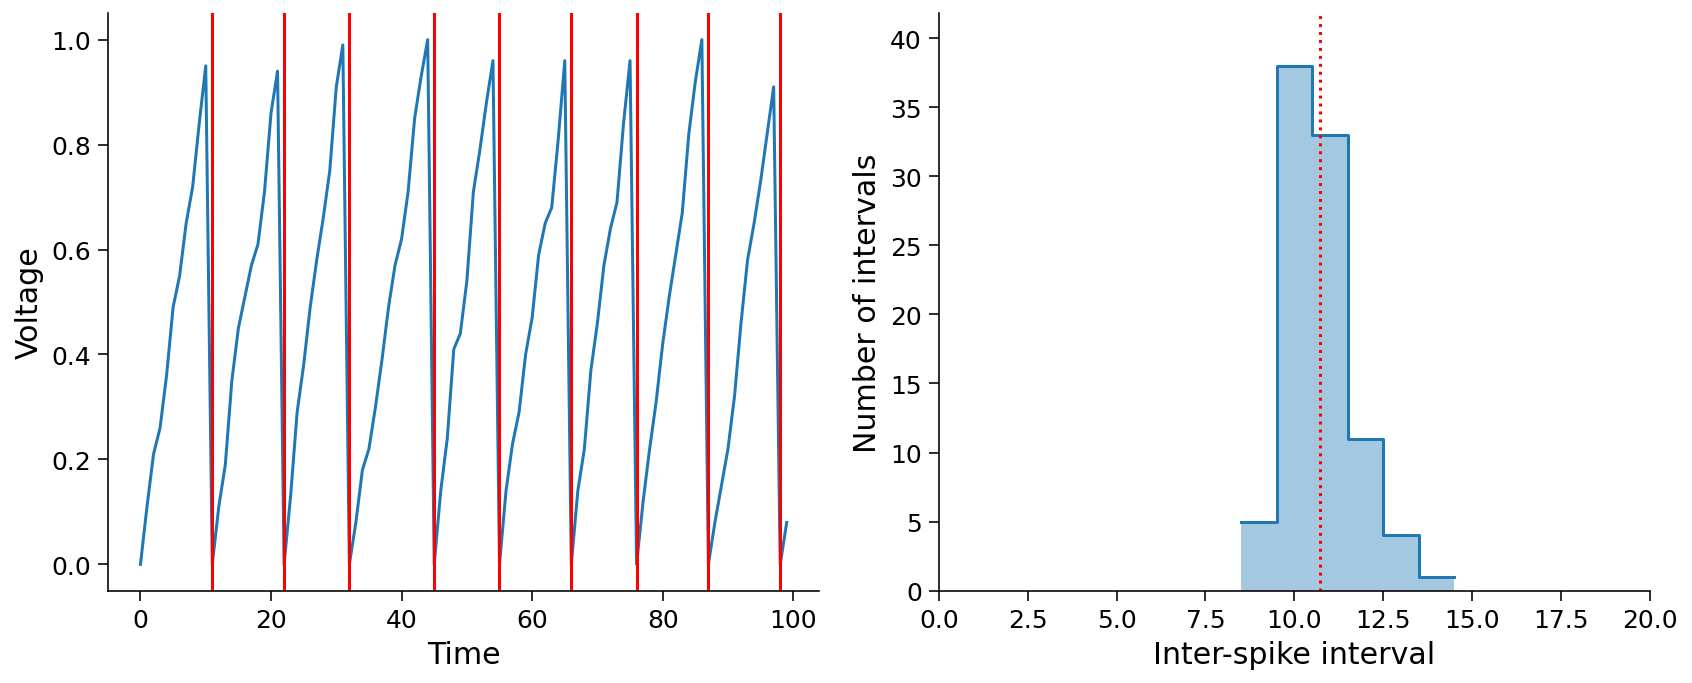

In [5]:
# to_remove solution
def lif_neuron(n_steps=1000, alpha=0.01, rate=10):
  """ Simulate a linear integrate-and-fire neuron.

  Args:
    n_steps (int): The number of time steps to simulate the neuron's activity.
    alpha (float): The input scaling factor
    rate (int): The mean rate of incoming spikes
  """
  # precompute Poisson samples for speed
  exc = stats.poisson(rate).rvs(n_steps)

  v = np.zeros(n_steps)
  spike_times = []
  for i in range(1, n_steps):

    dv = alpha * exc[i]

    v[i] = v[i-1] + dv
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0

  return v, spike_times

v, spike_times = lif_neuron()
plot_neuron_stats(v, spike_times)

## Interactive Demo: Linear-IF neuron
Like last time, you can now explore how various parametes of the LIF model influence the ISI distribution.

In [6]:
#@title

#@markdown You don't need to worry about how the code works – but you do need to **run the cell** to enable the sliders.

def _lif_neuron(n_steps=1000, alpha=0.01, rate=10):
  exc = stats.poisson(rate).rvs(n_steps)
  v = np.zeros(n_steps)
  spike_times = []
  for i in range(1, n_steps):
    dv = alpha * exc[i]
    v[i] = v[i-1] + dv
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0
  return v, spike_times

@widgets.interact(
  n_steps=widgets.FloatLogSlider(1000.0, min=2, max=4),
  alpha=widgets.FloatLogSlider(0.01, min=-2, max=-1),
  rate=widgets.IntSlider(10, min=5, max=20)
)
def plot_lif_neuron(n_steps=1000, alpha=0.01, rate=10):
  v, spike_times = _lif_neuron(int(n_steps), alpha, rate)
  plot_neuron_stats(v, spike_times)

interactive(children=(FloatLogSlider(value=1000.0, description='n_steps', min=2.0), FloatLogSlider(value=0.01,…

# Section 2: Inhibitory signals



Our linear integrate-and-fire neuron from the previous section was indeed able to produce spikes. However, our ISI histogram doesn't look much like empirical ISI histograms seen in Tutorial 1, which had an exponential-like shape. What is our model neuron missing, given that it doesn't behave like a real neuron?

In the previous model we only considered excitatory behavior -- the only way the membrane potential could decrease was upon a spike event. We know, however, that there are other factors that can drive $V_m$ down. First is the natural tendency of the neuron to return to some steady state or resting potential. We can update our previous model as follows:

\begin{align}
  dV_m = -{\beta}V_m + {\alpha}I
\end{align}

where $V_m$ is the current membrane potential and $\beta$ is some leakage factor. This is a basic form of the popular Leaky Integrate-and-Fire model neuron (for a more detailed discussion of the LIF Neuron, see the Appendix).

We also know that in addition to excitatory presynaptic neurons, we can have inhibitory presynaptic neurons as well. We can model these inhibitory neurons with another Poisson random variable:

\begin{align}
I = I_{exc} - I_{inh} \\
I_{exc} \sim \mathrm{Poisson}(\lambda_{exc}) \\
I_{inh} \sim \mathrm{Poisson}(\lambda_{inh})
\end{align}

where $\lambda_{exc}$ and $\lambda_{inh}$ are the average spike rates (per timestep) of the excitatory and inhibitory presynaptic neurons, respectively.

### Exercise 2: Compute $dV_m$ with inhibitory signals

For your second exercise, you will again write the code to compute the change in voltage $dV_m$, though now of the LIF model neuron described above. Like last time, the rest of the code needed to handle the neuron dynamics are provided for you, so you just need to fill in a definition for `dv` below.


In [7]:
def lif_neuron_inh(n_steps=1000, alpha=0.5, beta=0.1, exc_rate=10, inh_rate=10):
  """ Simulate a simplified leaky integrate-and-fire neuron with both excitatory
  and inhibitory inputs.

  Args:
    n_steps (int): The number of time steps to simulate the neuron's activity.
    alpha (float): The input scaling factor
    beta (float): The membrane potential leakage factor
    exc_rate (int): The mean rate of the incoming excitatory spikes
    inh_rate (int): The mean rate of the incoming inhibitory spikes
  """

  # precompute Poisson samples for speed
  exc = stats.poisson(exc_rate).rvs(n_steps)
  inh = stats.poisson(inh_rate).rvs(n_steps)

  v = np.zeros(n_steps)
  spike_times = []

  ###############################################################################
  # Students: compute dv, then comment out or remove the next line
  raise NotImplementedError("Excercise: compute the change in membrane potential")
  ################################################################################

  for i in range(1, n_steps):

    dv = ...

    v[i] = v[i-1] + dv
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0

  return v, spike_times

# Uncomment these lines do make the plot once you've completed the function
#v, spike_times = lif_neuron_inh()
#plot_neuron_stats(v, spike_times)

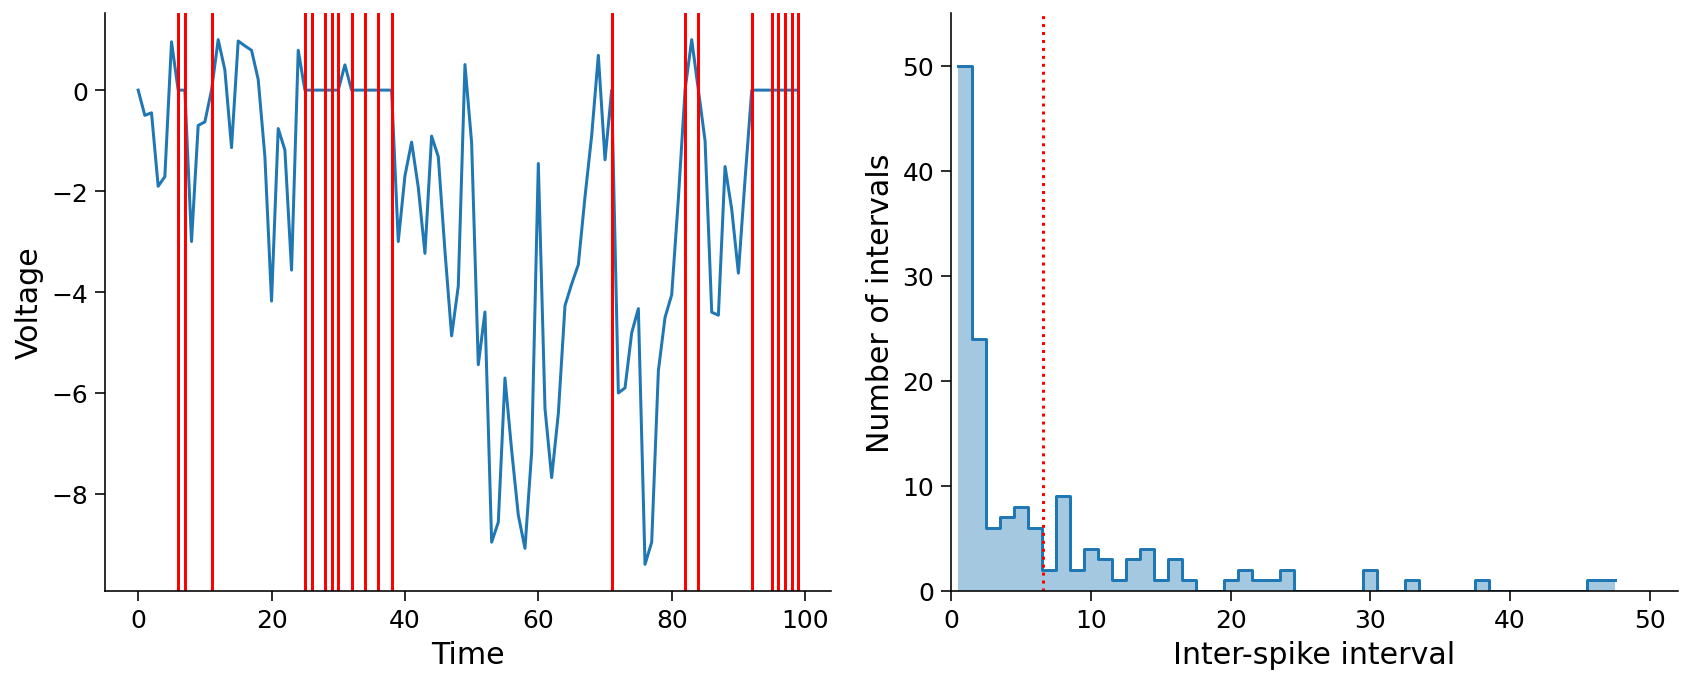

In [8]:
# to_remove solution
def lif_neuron_inh(n_steps=1000, alpha=0.5, beta=0.1, exc_rate=10, inh_rate=10):
  """ Simulate a simplified leaky integrate-and-fire neuron with both excitatory
  and inhibitory inputs.

  Args:
    n_steps (int): The number of time steps to simulate the neuron's activity.
    alpha (float): The input scaling factor
    beta (float): The membrane potential leakage factor
    exc_rate (int): The mean rate of the incoming excitatory spikes
    inh_rate (int): The mean rate of the incoming inhibitory spikes
  """
  # precompute Poisson samples for speed
  exc = stats.poisson(exc_rate).rvs(n_steps)
  inh = stats.poisson(inh_rate).rvs(n_steps)

  v = np.zeros(n_steps)
  spike_times = []
  for i in range(1, n_steps):

    dv = -beta * v[i-1] + alpha * (exc[i] - inh[i])

    v[i] = v[i-1] + dv
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0

  return v, spike_times

v, spike_times = lif_neuron_inh()

plot_neuron_stats(v, spike_times)

## Interactive Demo: LIF + inhibition neuron

In [9]:
#@title
#@markdown **Run the cell** to enable the sliders.
def _lif_neuron_inh(n_steps=1000, alpha=0.5, beta=0.1, exc_rate=10, inh_rate=10):
  """ Simulate a simplified leaky integrate-and-fire neuron with both excitatory
  and inhibitory inputs.

  Args:
    n_steps (int): The number of time steps to simulate the neuron's activity.
    alpha (float): The input scaling factor
    beta (float): The membrane potential leakage factor
    exc_rate (int): The mean rate of the incoming excitatory spikes
    inh_rate (int): The mean rate of the incoming inhibitory spikes
  """
  # precompute Poisson samples for speed
  exc = stats.poisson(exc_rate).rvs(n_steps)
  inh = stats.poisson(inh_rate).rvs(n_steps)

  v = np.zeros(n_steps)
  spike_times = []
  for i in range(1, n_steps):
    dv = -beta * v[i-1] + alpha * (exc[i] - inh[i])
    v[i] = v[i-1] + dv
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0

  return v, spike_times

@widgets.interact(n_steps=widgets.FloatLogSlider(1000.0, min=2.5, max=4),
                  alpha=widgets.FloatLogSlider(0.5, min=-1, max=1),
                  beta=widgets.FloatLogSlider(0.1, min=-1, max=0),
                  exc_rate=widgets.IntSlider(12, min=10, max=20),
                  inh_rate=widgets.IntSlider(12, min=10, max=20))
def plot_lif_neuron(n_steps=1000, alpha=0.5, beta=0.1, exc_rate=10, inh_rate=10):
  v, spike_times = _lif_neuron_inh(int(n_steps), alpha, beta, exc_rate, inh_rate)
  plot_neuron_stats(v, spike_times)

interactive(children=(FloatLogSlider(value=1000.0, description='n_steps', min=2.5), FloatLogSlider(value=0.5, …

---
# Section 3: Reflecting on how models

## Think! 3: Reflecting on how models

Please discuss the following questions for around 10 minutes with your group:

- Have you seen how models before?
- Have you ever done one?
- Why are how models useful?
- When are they possible? Does your field have how models?
- What do we learn from constructing them?

---
# Notation

\begin{align}
V_m &\quad \text{membrane potential} \\
dV_m &\quad \text{change in membrane potential}\\
C_m &\quad \text{membrane capacitance}\\
I &\quad \text{input current}\\
R_m &\quad \text{membrane resistance}:\\
V_\mathrm{rest} &\quad \text{resting potential}\\
\alpha &\quad \text{scaling factor for input current}\\
\beta &\quad \text{leakage factor}\\
\lambda &\quad \text{average spike rate}\\
\lambda_\mathrm{exc} &\quad \text{average spike rate for excitatory neurons}\\
\lambda_\mathrm{inh} &\quad \text{average spike rate for inhibitory neurons}\\
\end{align}

# Summary

In this tutorial we gained some intuition for the mechanisms that produce the observed behavior in our real neural data. First, we built a simple neuron model with excitatory input and saw that it's behavior, measured using the ISI distribution, did not match our real neurons. We then improved our model by adding leakiness and inhibitory input. The behavior of this balanced model was much closer to the real neural data.

# Bonus

### Why do neurons spike?

A neuron stores energy in an electric field across its cell membrane, by controlling the distribution of charges (ions) on either side of the membrane. This energy is rapidly discharged to generate a spike when the field potential (or membrane potential) crosses a threshold. The membrane potential may be driven toward or away from this threshold, depending on inputs from other neurons: excitatory or inhibitory, respectively. The membrane potential tends to revert to a resting potential, for example due to the leakage of ions across the membrane, so that reaching the spiking threshold depends not only on the amount of input ever received following the last spike, but also the timing of the inputs.

The storage of energy by maintaining a field potential across an insulating membrane can be modeled by a capacitor. The leakage of charge across the membrane can be modeled by a resistor. This is the basis for the leaky integrate-and-fire neuron model.

### The LIF Model Neuron

The full equation for the LIF neuron is

\begin{align}
C_{m}\frac{dV_m}{dt} = -(V_m - V_{rest})/R_{m} + I
\end{align}

where $C_m$ is the membrane capacitance, $R_M$ is the membrane resistance, $V_{rest}$ is the resting potential, and $I$ is some input current (from other neurons, an electrode, ...).

In our above examples we set many of these parameters to convenient values ($C_m = R_m = dt = 1$, $V_{rest} = 0$) to focus more on the general behavior of the model. However, these too can be manipulated to achieve different dynamics, or to ensure the dimensions of the problem are preserved between simulation units and experimental units (e.g. with $V_m$ given in millivolts, $R_m$ in megaohms, $t$ in milliseconds).

In [10]:
# Write your code and test below

